# colab CoNGA pipeline

This notebook will install the required packages, download the CoNGA package and some example datasets, and run a few analyses. You can save a copy of it and edit and run it. If you want to test CoNGA without going to the trouble of installing locally, you can upload your datafiles to a colab instance and run conga on them by changing the file locations in the 'Running' section below. Upload files using the 'file explorer' tab on the left.

# Installation

## Install `scanpy` (for single-cell) and `leiden` (for clustering)

`colab` comes with matplotlib, pandas, numpy, scipy, and a few others pre-installed. So you would probably need a few others in a local install into a clean environment. See the instructions in the CoNGA github readme.

If you are running this notebook locally, not in colab, note that these commmands will change whichever python environment was used to launch the notebook. And they also won't work if that environment doesn't match the kernel of this notebook. See the nice explanations here:

https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/

You could replace !pip with %pip if your notebook understands pip magic and that should help to sync up the two install locations...


In [ ]:
!pip install leidenalg scanpy 


## Install a tool for converting from SVG to PNG files

In [ ]:
!pip install cairosvg

## download the `conga` repository 

In [4]:
!git clone https://github.com/phbradley/conga.git

Cloning into 'conga'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 1250 (delta 47), reused 51 (delta 26), pack-reused 1168
Receiving objects: 100% (1250/1250), 13.39 MiB | 30.55 MiB/s, done.
Resolving deltas: 100% (832/832), done.


## compile the C++ implementation of TCRdist
This is optional for the core graph vs graph pipeline but will speed things up for large datasets and is required for tcr_clumping or tcr database matching

In [5]:
!cd conga/tcrdist_cpp/ ; make


g++ -O3 -std=c++11 -Wall -I ./include/ -o ./bin/find_neighbors ./src/find_neighbors.cc
g++ -O3 -std=c++11 -Wall -I ./include/ -o ./bin/calc_distributions ./src/calc_distributions.cc
g++ -O3 -std=c++11 -Wall -I ./include/ -o ./bin/count_matches_single_chain ./src/count_matches_single_chain.cc
g++ -O3 -std=c++11 -Wall -I ./include/ -o ./bin/count_matches_paired ./src/count_matches_paired.cc
g++ -O3 -std=c++11 -Wall -I ./include/ -o ./bin/find_paired_matches ./src/find_paired_matches.cc


## add `conga` to our path so we can `import` it
The `conga/` github repository folder contains within it the `conga` package folder, which is what we need to be able to find in our path when we are trying to `import conga`.  

In [6]:
import sys
sys.path.append('conga/')

## Download some example 10x datasets. 
See the README file contained in the download folder for license information. 

In [7]:
!wget https://www.dropbox.com/s/r7rpsftbtxl89y5/conga_example_datasets_v1.zip
!unzip conga_example_datasets_v1.zip

--2021-02-10 14:54:23--  https://www.dropbox.com/s/r7rpsftbtxl89y5/conga_example_datasets_v1.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r7rpsftbtxl89y5/conga_example_datasets_v1.zip [following]
--2021-02-10 14:54:23--  https://www.dropbox.com/s/raw/r7rpsftbtxl89y5/conga_example_datasets_v1.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc014cf5e1e728da2a09b6edd796.dl.dropboxusercontent.com/cd/0/inline/BIoHrsG5kUGFr4vJLtdngeKaTycmdc_YxEzxPMHCJdsVLQ_xljguxTo99TJMvskTY-PBOCqh6CBVjCoUa5H0iasnoxYwQswx81qgARd61JP3qc8dIAQEaNKmRXs_ckeT9_U/file# [following]
--2021-02-10 14:54:24--  https://uc014cf5e1e728da2a09b6edd796.dl.dropboxusercontent.com/cd/0/inline/BIoHrsG5kUGFr4vJLtdngeKaTycmdc_YxEzxPMHCJdsVLQ_xljguxTo99TJM

In [8]:
!cat conga_example_datasets_v1/README.md

These datasets were made publicly available by 10X Genomics under a creative commons 3.0 attribution license. 

Here is a link to the text of the license:
https://creativecommons.org/licenses/by/3.0/us/legalcode

These are the relevant download links:

https://support.10xgenomics.com/single-cell-vdj/datasets/3.0.0/vdj_v1_mm_balbc_pbmc_5gex
https://support.10xgenomics.com/single-cell-vdj/datasets/3.1.0/vdj_v1_hs_pbmc3
https://support.10xgenomics.com/single-cell-vdj/datasets/4.0.0/sc5p_v1p1_hs_melanoma_10k
https://support.10xgenomics.com/single-cell-vdj/datasets/2.2.0/vdj_v1_hs_nsclc_b



In [9]:
!ls conga_example_datasets_v1/

README.md
sc5p_v1p1_hs_melanoma_10k_b_filtered_contig_annotations.csv
sc5p_v1p1_hs_melanoma_10k_filtered_feature_bc_matrix.h5
vdj_v1_hs_nsclc_5gex_filtered_gene_bc_matrices_h5.h5
vdj_v1_hs_nsclc_b_filtered_contig_annotations.csv
vdj_v1_hs_pbmc3_5gex_filtered_gene_bc_matrices_h5.h5
vdj_v1_hs_pbmc3_t_filtered_contig_annotations.csv
vdj_v1_mm_balbc_pbmc_5gex_filtered_gene_bc_matrices_h5.h5
vdj_v1_mm_balbc_pbmc_t_filtered_contig_annotations.csv


# Running

In [10]:
%matplotlib inline
import conga
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image               # for looking at some of 
from IPython.display import display # the output images.


## Input data, output paths
You could upload your own data to colab and analyze it. Just change these filenames to point to the correct locations.

In [11]:
# you might have to change these paths depending on what you want to analyze
gex_datafile = 'conga_example_datasets_v1/vdj_v1_hs_pbmc3_5gex_filtered_gene_bc_matrices_h5.h5'
gex_datatype = '10x_h5' # other possibilities right now: ['10x_mtx', 'h5ad'] (h5ad from scanpy)
tcr_datafile = 'conga_example_datasets_v1/vdj_v1_hs_pbmc3_t_filtered_contig_annotations.csv'
organism = 'human'

clones_file = 'vdj_v1_hs_pbmc3_clones.tsv'
outfile_prefix = 'hs_pbmc3_test1'


## Setup for conga: make a TCRdist clones_file and compute kernel PCs

In [12]:
# this creates the TCRdist 'clones file'
conga.tcrdist.make_10x_clones_file.make_10x_clones_file(
    tcr_datafile, organism, clones_file )

# this command will create another file with the kernel PCs for subsequent reading by conga
conga.preprocess.make_tcrdist_kernel_pcs_file_from_clones_file( clones_file, organism )

ab_counts: [((1, 1), 2909), ((2, 1), 281), ((1, 2), 101), ((2, 2), 65)]
old_unpaired_barcodes: 569 old_paired_barcodes: 3356 new_stringent_paired_barcodes: 3190
compute tcrdist distance matrix for 3000 clonotypes
Using C++ TCRdist calculator
util.run_command: cmd= conga/tcrdist_cpp/bin/find_neighbors -f vdj_v1_hs_pbmc3_clones_AB.dist_50_kpcs_tcrs.tsv --only_tcrdists -d conga/tcrdist_cpp/db/tcrdist_info_human.txt -o vdj_v1_hs_pbmc3_clones_AB.dist_50_kpcs
running KernelPCA with None kernel distance matrix shape= (3000, 3000) D.max()= 502.0 force_Dmax= None
writing TCRdist kernel PCs to outfile: vdj_v1_hs_pbmc3_clones_AB.dist_50_kpcs


## Read the data, create a scanpy AnnData object with everything inside

In [13]:
adata = conga.preprocess.read_dataset(gex_datafile, gex_datatype, clones_file )

# store the organism info in adata
adata.uns['organism'] = organism

adata

reading: conga_example_datasets_v1/vdj_v1_hs_pbmc3_5gex_filtered_gene_bc_matrices_h5.h5 of type 10x_h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
conga/conga/preprocess.py:239: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview: # this is so weird


total barcodes: 7231 (7231, 33538)
reading: vdj_v1_hs_pbmc3_clones.tsv
reading: vdj_v1_hs_pbmc3_clones_AB.dist_50_kpcs
Reducing to the 3176 barcodes (out of 7231) with paired TCR sequence data


conga/conga/preprocess.py:394: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  assert not adata.isview
conga/conga/preprocess.py:397: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  assert not adata.isview


AnnData object with n_obs × n_vars = 3176 × 33538
    obs: 'va', 'ja', 'cdr3a', 'cdr3a_nucseq', 'vb', 'jb', 'cdr3b', 'cdr3b_nucseq'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'organism'
    obsm: 'X_pca_tcr'

Note that the AnnData object contains the TCR sequence information in the `obs` array, stored with the  `['va',..., 'cdr3b_nucseq']` fields.

It also contains the TCRdist kernel PCS in the `obsm` array stored under the key `'X_pca_tcr'`

In [14]:
# top 50 TCRdist kPCS 
adata.obsm['X_pca_tcr'].shape

(3176, 50)

In [15]:
# CDR3-alpha regions:
adata.obs['cdr3a'].head(3)

AAACCTGAGATCTGAA-1    CAASIGPLGTGTASKLTF
AAACCTGAGGAACTGC-1          CAASDNTDKLIF
AAACCTGAGGAGTCTG-1      CAVEANNAGNNRKLIW
Name: cdr3a, dtype: object

## Do some very basic scGEX filtering

You could customize this or replace it with something else entirely.

In [16]:
adata = conga.preprocess.filter_and_scale( adata )

conga/conga/preprocess.py:456: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  assert not adata.isview


min_genes not set. Using default 200
n_genes not set. Using default 2500
percent_mito not set. Using default 0.1


conga/conga/preprocess.py:458: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  assert not adata.isview
conga/conga/preprocess.py:490: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  assert not adata.isview
conga/conga/preprocess.py:492: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  assert not adata.isview
conga/conga/preprocess.py:496: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  assert not adata.isview


filtered out 80 cells with more than 2500 genes
filtered out 26 cells with more than 0.1 percent mito
get_feature_types_varname: feature_types feature_type_counts: [('Gene Expression', 14939)]
num antibody features: 0


... storing 'va' as categorical
... storing 'ja' as categorical
... storing 'cdr3a' as categorical
... storing 'cdr3a_nucseq' as categorical
... storing 'vb' as categorical
... storing 'jb' as categorical
... storing 'cdr3b' as categorical
... storing 'cdr3b_nucseq' as categorical


excluding 94 TR genes (89 variable)
excluding 1 sexlinked genes
total of 1022 variable genes (3070, 14939)


... storing 'feature_types' as categorical
... storing 'genome' as categorical
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Now we reduce to a single cell per TCR clonotype

Do this by computing GEX distances and picking the most representative cell for each clonotype (the one with the smallest average distance to all other cells in the clonotype)

In [17]:
adata = conga.preprocess.reduce_to_single_cell_per_clone( adata )

adata

compute pca to find rep cell for each clone (3070, 1022)
num_clones: 2896
Normalize and logging matrix...
get_feature_types_varname: feature_types feature_type_counts: [('Gene Expression', 1022)]
feature_types counter: [('Gene Expression', 14939)]
normalize_and_log_the_raw_matrix: adata.raw.X.max()=  588.0
found 500 of 512 good_genes in var_names  organism=human
choose representative cell for clone: 0 2896 (3070, 1022)
choose representative cell for clone: 1000 2896 (3070, 1022)
choose representative cell for clone: 2000 2896 (3070, 1022)
reduce from 3070 cells to 2896 cells (one per clonotype)
normalize_and_log_the_raw_matrix:: matrix is already logged


AnnData object with n_obs × n_vars = 2896 × 1022
    obs: 'va', 'ja', 'cdr3a', 'cdr3a_nucseq', 'vb', 'jb', 'cdr3b', 'cdr3b_nucseq', 'n_genes', 'percent_mito', 'n_counts', 'clone_sizes', 'gex_variation'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'organism', 'log1p', 'hvg', 'pca', 'raw_matrix_is_logged', 'X_igex_genes'
    obsm: 'X_pca_tcr', 'X_igex'
    varm: 'PCs'
    layers: 'scaled'

## Now that we've reduced to a single cell per clonotype, run clustering and dimensionality reduction for GEX and for TCR

In [18]:
adata = conga.preprocess.cluster_and_tsne_and_umap( adata )


computing X_pca_gex using sc.tl.pca
ran leiden clustering: leiden_gex
ran leiden clustering: leiden_tcr


In [19]:
adata

AnnData object with n_obs × n_vars = 2896 × 1022
    obs: 'va', 'ja', 'cdr3a', 'cdr3a_nucseq', 'vb', 'jb', 'cdr3b', 'cdr3b_nucseq', 'n_genes', 'percent_mito', 'n_counts', 'clone_sizes', 'gex_variation', 'leiden_gex', 'clusters_gex', 'leiden_tcr', 'clusters_tcr'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'organism', 'log1p', 'hvg', 'pca', 'raw_matrix_is_logged', 'X_igex_genes', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca_tcr', 'X_igex', 'X_pca_gex', 'X_umap_gex', 'X_gex_2d', 'X_umap_tcr', 'X_tcr_2d'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'distances', 'connectivities'

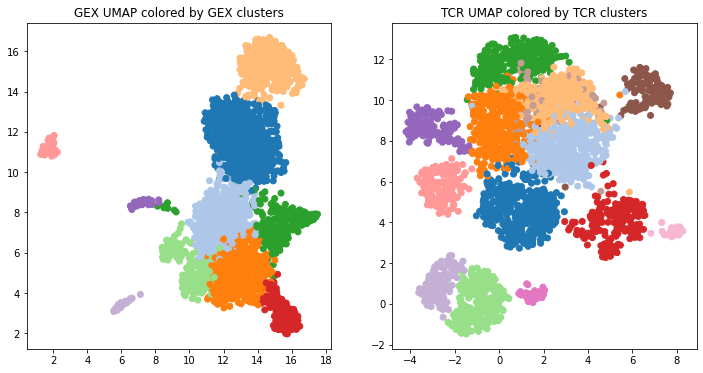

In [20]:
plt.figure(figsize=(12,6))
plt.subplot(121)
xy = adata.obsm['X_gex_2d']
clusters = np.array(adata.obs['clusters_gex'])
cmap = plt.get_cmap('tab20')
colors = [ cmap.colors[x] for x in clusters]
plt.scatter( xy[:,0], xy[:,1], c=colors)
plt.title('GEX UMAP colored by GEX clusters')

plt.subplot(122)
xy = adata.obsm['X_tcr_2d']
clusters = np.array(adata.obs['clusters_tcr'])
cmap = plt.get_cmap('tab20')
colors = [ cmap.colors[x] for x in clusters]
plt.scatter( xy[:,0], xy[:,1], c=colors)
plt.title('TCR UMAP colored by TCR clusters');



## Compute the GEX and TCR neighbor sets

Also do a bit of other miscellaneous setup

In [21]:
# these are the nbrhood sizes, as a fraction of the entire dataset:
nbr_fracs = [0.01, 0.1]

# we use this nbrhood size for computing the nndists
nbr_frac_for_nndists = 0.01

all_nbrs, nndists_gex, nndists_tcr = conga.preprocess.calc_nbrs(
    adata, nbr_fracs, also_calc_nndists=True, nbr_frac_for_nndists=nbr_frac_for_nndists)

# stash these in obs array, they are used in a few places...                                                                                                                
adata.obs['nndists_gex'] = nndists_gex
adata.obs['nndists_tcr'] = nndists_tcr

conga.preprocess.setup_tcr_cluster_names(adata) #stores in adata.uns                                                                                                        


compute D gex 2896
argpartitions: 0.01 2896 gex
calculate nndists: gex 0.01
DONE calculating nndists: gex 0.01
argpartitions: 0.1 2896 gex
compute D tcr 2896
argpartitions: 0.01 2896 tcr
calculate nndists: tcr 0.01
DONE calculating nndists: tcr 0.01
argpartitions: 0.1 2896 tcr
setup_tcr_cluster_names: ['0_av8', '1', '2', '3', '4_AV12', '5_av38', '6_BV20', '7_AV26', '8_AV9', '9_AV19', '10_AV1', '11', '12_BV20', '13_AV1']


## Run graph-vs-graph analysis

In [22]:
results = conga.correlations.run_graph_vs_graph(adata, all_nbrs)

conga_scores = adata.obs['conga_scores']

good_mask = ( conga_scores <= 1.0 )
adata.obs['good_score_mask'] = good_mask

print(f'found {np.sum(good_mask)} conga hits')

results.sort_values('conga_score', inplace=True)

results.head(3)

find_neighbor_neighbor_interactions:
find_neighbor_cluster_interactions:
find_neighbor_cluster_interactions:
find_neighbor_neighbor_interactions:
find_neighbor_cluster_interactions:
find_neighbor_cluster_interactions:
found 158 conga hits


conga_score  num_neighbors_gex  ...  num_neighbors  cluster_size
375  1.175707e-46                NaN  ...          289.0         137.0
417  2.055523e-46                NaN  ...          289.0         131.0
401  4.384807e-46                NaN  ...          289.0         137.0

[3 rows x 11 columns]

### Write the results to a file

In [23]:
# write the results to a tsv file
clusters_gex = np.array(adata.obs['clusters_gex'])
clusters_tcr = np.array(adata.obs['clusters_tcr'])

indices = results['clone_index']
results['gex_cluster'] = clusters_gex[indices]
results['tcr_cluster'] = clusters_tcr[indices]
for tag in 'va ja cdr3a vb jb cdr3b'.split():
    results[tag] = list(adata.obs[tag][indices])
tsvfile = outfile_prefix+'_graph_vs_graph_hits.tsv'
print('saving graph-vs-graph results to file:',tsvfile)

results.to_csv(tsvfile, sep='\t', index=False)


saving graph-vs-graph results to file: hs_pbmc3_test1_graph_vs_graph_hits.tsv


### Make a scatterplot colored by conga score

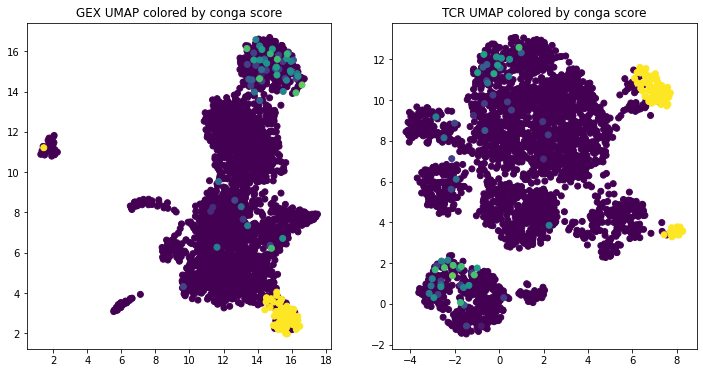

In [24]:
#put the conga hits on top
colors = np.sqrt(np.maximum(-1*np.log10(conga_scores),0.0))
reorder = np.argsort(colors)

plt.figure(figsize=(12,6))
plt.subplot(121)
xy = adata.obsm['X_gex_2d']
plt.scatter( xy[reorder,0], xy[reorder,1], c=colors[reorder], vmin=0, vmax=np.sqrt(5))
plt.title('GEX UMAP colored by conga score')

plt.subplot(122)
xy = adata.obsm['X_tcr_2d']
plt.scatter( xy[reorder,0], xy[reorder,1], c=colors[reorder], vmin=0, vmax=np.sqrt(5))
plt.title('TCR UMAP colored by conga score');


## Make the bicluster logo plots

[((6, 10), 76), ((6, 13), 22), ((3, 9), 16), ((3, 4), 13), ((3, 5), 10), ((3, 2), 5), ((1, 7), 2), ((1, 8), 2), ((7, 10), 1), ((4, 4), 1), ((3, 11), 1), ((4, 9), 1), ((1, 2), 1), ((3, 7), 1), ((1, 1), 1), ((4, 5), 1), ((1, 3), 1), ((3, 1), 1), ((1, 0), 1), ((5, 8), 1)]
making tcr score table: ['alphadist', 'cd8', 'cdr3len', 'imhc', 'mait', 'inkt', 'nndists_tcr', 'af1', 'af2', 'af3', 'af4', 'af5', 'alpha', 'beta', 'charge', 'core', 'disorder', 'hydropathy', 'kf1', 'kf10', 'kf2', 'kf3', 'kf4', 'kf5', 'kf6', 'kf7', 'kf8', 'kf9', 'mjenergy', 'polarity', 'rim', 'strength', 'surface', 'turn', 'volume']


... storing 'test' as categorical


[((6, 10), 76), ((6, 13), 22), ((3, 9), 16), ((3, 4), 13), ((3, 5), 10), ((3, 2), 5), ((1, 7), 2), ((1, 8), 2), ((7, 10), 1), ((4, 4), 1), ((3, 11), 1), ((4, 9), 1), ((1, 2), 1), ((3, 7), 1), ((1, 1), 1), ((4, 5), 1), ((1, 3), 1), ((3, 1), 1), ((1, 0), 1), ((5, 8), 1)]
run rank_genes_groups [('none', 2754), ('clp_6_10', 76), ('clp_6_13', 22), ('clp_3_9', 16), ('clp_3_4', 13), ('clp_3_5', 10), ('clp_3_2', 5)]
clp: 0 6 hs_pbmc3_test1_bicluster_logos.png
clp: 1 6 hs_pbmc3_test1_bicluster_logos.png
clp: 2 6 hs_pbmc3_test1_bicluster_logos.png
clp: 3 6 hs_pbmc3_test1_bicluster_logos.png
clp: 4 6 hs_pbmc3_test1_bicluster_logos.png
clp: 5 6 hs_pbmc3_test1_bicluster_logos.png


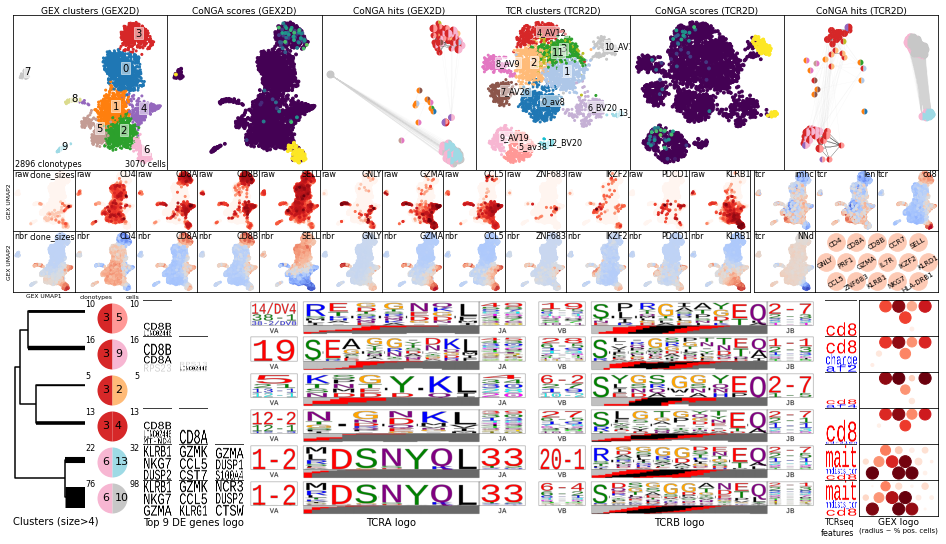

In [25]:
nbrs_gex, nbrs_tcr = all_nbrs[0.1]

min_cluster_size = 5

# calc tcr sequence features of good cluster pairs
good_bicluster_tcr_scores = conga.correlations.calc_good_cluster_tcr_features(
    adata, good_mask, clusters_gex, clusters_tcr, conga.tcr_scoring.all_tcr_scorenames, verbose=False,
    min_count=min_cluster_size)

# run rank_genes on most common biclusters
rank_genes_uns_tag = 'rank_genes_good_biclusters'
conga.correlations.run_rank_genes_on_good_biclusters(
    adata, good_mask, clusters_gex, clusters_tcr, min_count=min_cluster_size, key_added= rank_genes_uns_tag)

gex_header_tcr_score_names = ['imhc', 'cdr3len', 'cd8', 'nndists_tcr']

logo_pngfile = outfile_prefix+'_bicluster_logos.png'

conga.plotting.make_logo_plots(
    adata, nbrs_gex, nbrs_tcr, min_cluster_size, logo_pngfile,
    good_bicluster_tcr_scores=good_bicluster_tcr_scores,
    rank_genes_uns_tag = rank_genes_uns_tag,
    gex_header_tcr_score_names = gex_header_tcr_score_names )


### The image that was saved to disk is higher resolution than the one above here in the notebook 
This should be the one on disk, below. Click on it to zoom in even more.

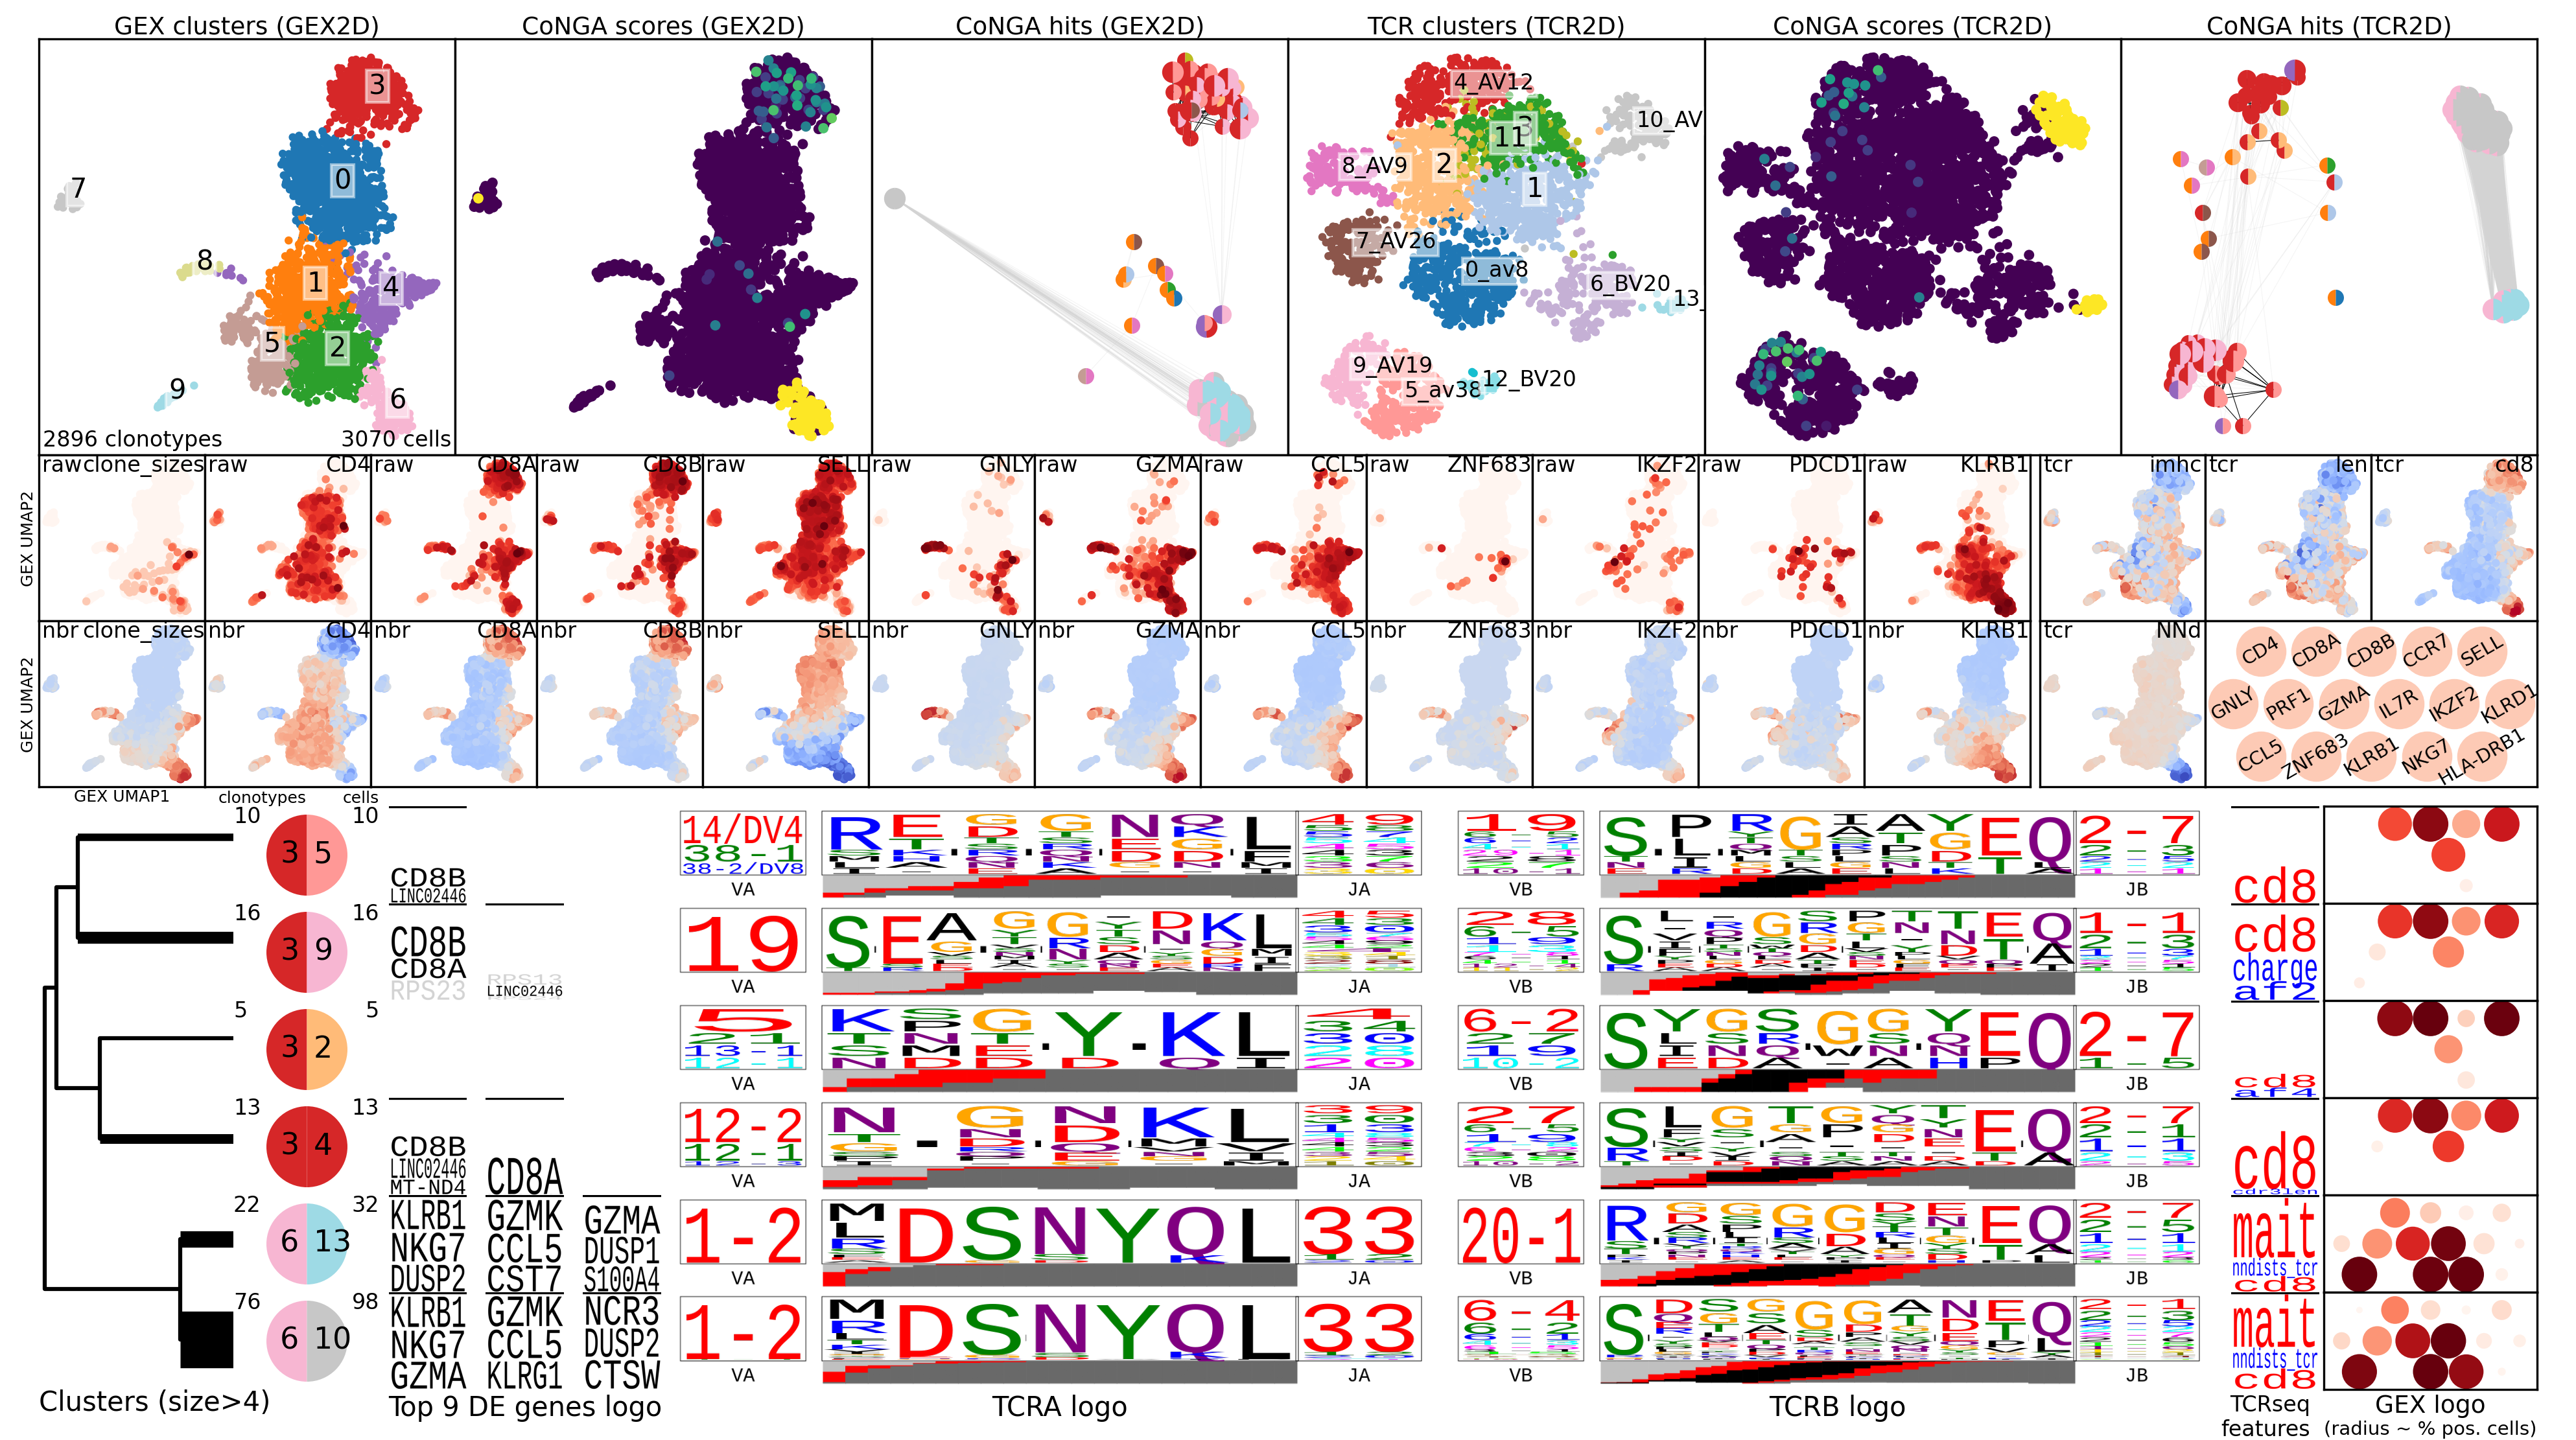

In [26]:
image = Image.open(logo_pngfile)
display(image)

## Run graph-vs-feature analysis, comparing the TCR graph to GEX features (mostly gene expression)

finding biased GEX features for nbrhoods with size 0.01 (2896, 28)
finding biased GEX features for nbrhoods with size 0.1 (2896, 289)
making: hs_pbmc3_test1_tcr_nbr_graph_vs_gex_features.tsv
making: hs_pbmc3_test1_tcr_nbr_graph_vs_gex_features.png


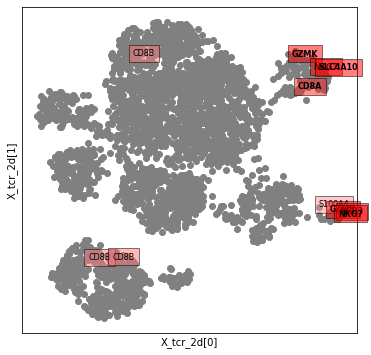

In [28]:
pval_threshold = 1.
results = []
for nbr_frac in nbr_fracs:
    nbrs_gex, nbrs_tcr = all_nbrs[nbr_frac]
    print('finding biased GEX features for nbrhoods with size', nbr_frac, nbrs_gex.shape)
    results.append( conga.correlations.tcr_nbrhood_rank_genes_fast( adata, nbrs_tcr, pval_threshold, verbose=False))
    results[-1]['nbr_frac'] = nbr_frac

# save the results to a file
tsvfile = outfile_prefix+'_tcr_nbr_graph_vs_gex_features.tsv'
print('making:', tsvfile)
results_df = pd.concat(results, ignore_index=True)
results_df.to_csv(tsvfile, index=False, sep='\t')

pngfile = outfile_prefix+'_tcr_nbr_graph_vs_gex_features.png'
print('making:', pngfile)
conga.plotting.plot_ranked_strings_on_cells(
    adata, results_df, 'X_tcr_2d', 'clone_index', 'mwu_pvalue_adj', 1.0, 'feature', pngfile)

### Plot the top GEX features on the TCR UMAP landscape

making: hs_pbmc3_test1_tcr_nbr_graph_vs_gex_features_panels.png
SLC4A10
CST7
CD8B
GZMK
S100A4
CD8A
KLRB1
NKG7
NCR3


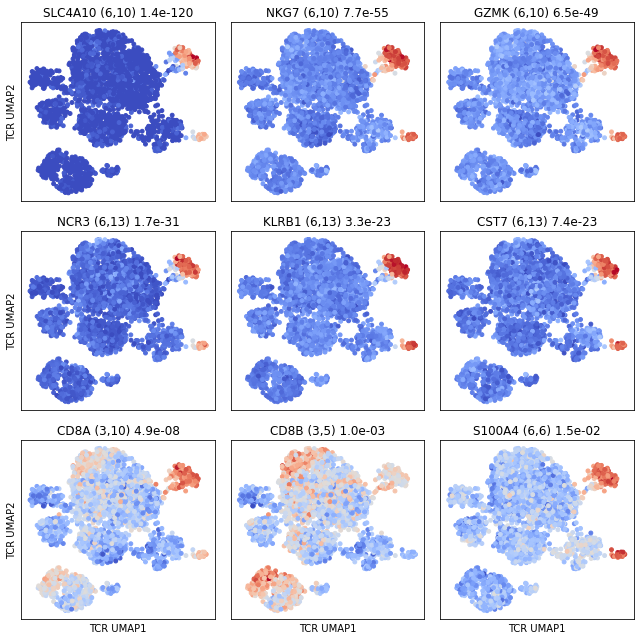

In [29]:
pngfile = outfile_prefix+'_tcr_nbr_graph_vs_gex_features_panels.png'
print('making:', pngfile)
conga.plotting.make_feature_panel_plots(adata, 'tcr', all_nbrs, results_df, pngfile)

## Run graph-vs-features analysis, comparing the GEX graph to TCR features

making tcr score table: ['alphadist', 'cd8', 'cdr3len', 'imhc', 'mait', 'inkt', 'nndists_tcr', 'af1', 'af2', 'af3', 'af4', 'af5', 'alpha', 'beta', 'charge', 'core', 'disorder', 'hydropathy', 'kf1', 'kf10', 'kf2', 'kf3', 'kf4', 'kf5', 'kf6', 'kf7', 'kf8', 'kf9', 'mjenergy', 'polarity', 'rim', 'strength', 'surface', 'turn', 'volume']
making tcr score table: ['alphadist', 'cd8', 'cdr3len', 'imhc', 'mait', 'inkt', 'nndists_tcr', 'af1', 'af2', 'af3', 'af4', 'af5', 'alpha', 'beta', 'charge', 'core', 'disorder', 'hydropathy', 'kf1', 'kf10', 'kf2', 'kf3', 'kf4', 'kf5', 'kf6', 'kf7', 'kf8', 'kf9', 'mjenergy', 'polarity', 'rim', 'strength', 'surface', 'turn', 'volume']
making: hs_pbmc3_test1_gex_nbr_graph_vs_tcr_features.tsv
making: hs_pbmc3_test1_gex_nbr_graph_vs_tcr_features.png


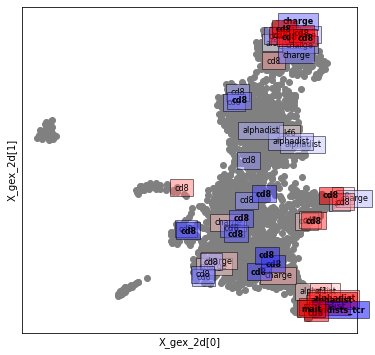

In [30]:
pval_threshold = 1.
results = []
tcr_score_names = conga.tcr_scoring.all_tcr_scorenames # the TCR features to use
for nbr_frac in nbr_fracs:
    nbrs_gex, nbrs_tcr = all_nbrs[nbr_frac]
    results.append( conga.correlations.gex_nbrhood_rank_tcr_scores(
        adata, nbrs_gex, tcr_score_names, pval_threshold, verbose=False ))
    results[-1]['nbr_frac'] = nbr_frac
results_df = pd.concat(results, ignore_index=True)

tsvfile = outfile_prefix+'_gex_nbr_graph_vs_tcr_features.tsv'
print('making:', tsvfile)
results_df.to_csv(tsvfile, index=False, sep='\t')

pngfile = outfile_prefix+'_gex_nbr_graph_vs_tcr_features.png'
print('making:', pngfile)

conga.plotting.plot_ranked_strings_on_cells(
    adata, results_df, 'X_gex_2d', 'clone_index', 'mwu_pvalue_adj', 1.0, 'feature', pngfile,
    direction_column='ttest_stat')

### Plot the top TCR score hits on the GEX UMAP landscape

making: hs_pbmc3_test1_gex_nbr_graph_vs_tcr_features_panels.png
nndists_tcr
charge
alphadist
cd8
af1
mait


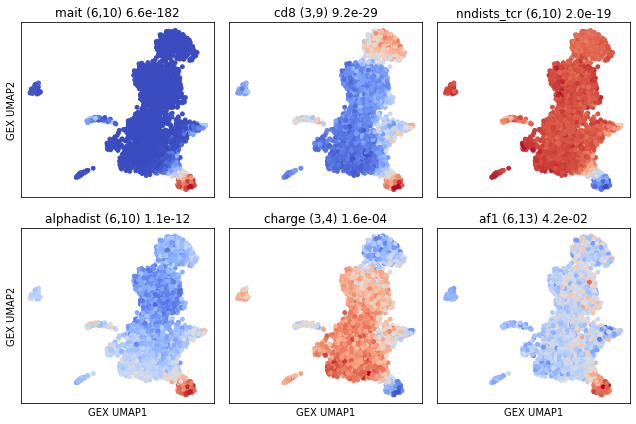

In [31]:
pngfile = outfile_prefix+'_gex_nbr_graph_vs_tcr_features_panels.png'
print('making:', pngfile)
conga.plotting.make_feature_panel_plots(adata, 'gex', all_nbrs, results_df, pngfile)

## Match the TCRs in the dataset to TCRs from the literature


In [36]:
# the default num_random_samples... of 50,000 would probably be just fine.
# Larger value here makes results a bit more precise. 
match_results = conga.tcr_clumping.match_adata_tcrs_to_db_tcrs(
    adata, num_random_samples_for_bg_freqs=500000)

tcr_clumping.match_adata_tcrs_to_db_tcrs: Matching to default literature TCR database; for more info see conga/data/new_paired_tcr_db_for_matching_nr_README.txt
Matching to paired tcrs in conga/conga/data/new_paired_tcr_db_for_matching_nr.tsv
pvalue_adjustment: 12299312 2896 4247
parse_tcr_junctions: 0 2896
parse_tcr_junctions: 1000 2896
parse_tcr_junctions: 2000 2896
success_rate: 85.27
success_rate: 94.08
util.run_command: cmd= conga/tcrdist_cpp/bin/calc_distributions -f tmp_nbrs1587_tcrs.tsv -m 200 -d conga/tcrdist_cpp/db/tcrdist_info_human.txt -a tmp_nbrs1587_bg_achains.tsv -b tmp_nbrs1587_bg_bchains.tsv -o tmp_nbrs1587_dists.tsv
find_significant_tcrdist_matches:: max_dist: 200 max_dist_for_matching: 117
util.run_command: cmd= conga/tcrdist_cpp/bin/find_paired_matches -i temp_query_tcrs.tsv -j temp_db_tcrs.tsv -t 117 -d conga/tcrdist_cpp/db/tcrdist_info_human.txt -o temp_tcr_matching.tsv


### Here we can see two likely EBV BMLF1 TCRs, a MAIT TCR, and what looks like an iNKT TCR matching to an autoimmune sample in the McPAS dataset (with borderline significance) 

In [37]:
match_results.sort_values('pvalue_adj', inplace=True)#may already be sorted this way...
match_results.drop_duplicates(subset=['clone_index']) # just show top match for each clonotype

tcrdist  pvalue_adj  clone_index  ...  db_db db_mhc_trim             barcode
3       33    0.021794         2354  ...  vdjdb        A*02  TGAAAGAAGACAGAGA-1
0       36    0.120041           42  ...    pdb         MR1  CCACGGACACCGAAAG-1
2       48    0.132488          188  ...  vdjdb        A*02  CACACAACACCAGCAC-1
1       78    0.581856          159  ...  mcpas         NaN  AGTGTCAAGGCAGGTT-1

[4 rows x 27 columns]

## Look for evidence of TCR sequence convergence ('TCR clumping')
In this case it seems to be just the MAIT cells that we find.

In [ ]:
results = conga.tcr_clumping.assess_tcr_clumping(adata)

In [43]:
# the top results:
results.sort_values('pvalue_adj', inplace=True)
results.head()

clump_type  clone_index  ...            cdr3b  clumping_group
28     global           85  ...  CASSDTGGEYNEQFF               1
70     global          118  ...  CASSDLAGPTDTQYF               1
46     global           99  ...   CASSPAGGADTQYF               1
84     global          132  ...  CASSSSGGATDTQYF               1
2      global           25  ...  CASSDTSGGADTQYF               1

[5 rows x 14 columns]

Here are the non-MAIT clumping hits (from the logos below we can see that groups 1 and 2 are the MAITs):

In [46]:
# drop duplicates because we test multiple distance thresholds so a single clonotype
# can occur more than once in the list...
results[results.clumping_group>2].drop_duplicates(subset='clone_index')

clump_type  clone_index  ...               cdr3b  clumping_group
105     global         2421  ...     CASSKGRTLQETQYF               6
108     global         2462  ...     CASSSGRMIQETQYF               6
101     global         1255  ...     CASSLAGGNTGELFF               5
104     global         2420  ...     CASSSGRQAQETQYF               6
100     global         1254  ...     CASSLAGGNTGELFF               5
99      global         1028  ...       CASSPGQITEAFF               4
98      global         1027  ...       CASSVGQITEAFF               4
102     global         2419  ...     CASSLGRTSSETQYF               6
97      global          363  ...  CASSNTIGQGSSTDTQYF               3

[9 rows x 14 columns]

[((0, 1), 51), ((0, 2), 17), ((0, 6), 4), ((0, 4), 2), ((0, 5), 2), ((0, 3), 1)]
making tcr score table: ['alphadist', 'cd8', 'cdr3len', 'imhc', 'mait', 'inkt', 'nndists_tcr', 'af1', 'af2', 'af3', 'af4', 'af5', 'alpha', 'beta', 'charge', 'core', 'disorder', 'hydropathy', 'kf1', 'kf10', 'kf2', 'kf3', 'kf4', 'kf5', 'kf6', 'kf7', 'kf8', 'kf9', 'mjenergy', 'polarity', 'rim', 'strength', 'surface', 'turn', 'volume']
gex_good_clp_score:  0.00e+00  0.00e+00  411.54 clp  6 10   1.000   0.017 mait            TRAV1-2*01 TRAJ12*01 CAGMDSSYKLIF TRBV6-4*01 TRBJ2-3*01 CASSDTSGGADTQYF mf: 1.000 25
gex_good_clp_score:  3.85e-52  6.20e-14   31.46 clp  6 10  88.490  61.125 alphadist       TRAV1-2*01 TRAJ12*01 CAGMDSSYKLIF TRBV6-4*01 TRBJ2-3*01 CASSDTSGGADTQYF mf: 1.000 25
gex_good_clp_score:  6.40e-35  4.29e-32  -33.76 clp  6 10   0.374   0.550 nndists_tcr     TRAV1-2*01 TRAJ12*01 CAGMDSSYKLIF TRBV6-4*01 TRBJ2-3*01 CASSDTSGGADTQYF mf: 1.000 25
gex_good_clp_score:  3.26e-31  1.35e-30   27.44 clp  6 10   

... storing 'test' as categorical


[((0, 1), 51), ((0, 2), 17), ((0, 6), 4), ((0, 4), 2), ((0, 5), 2), ((0, 3), 1)]
run rank_genes_groups [('none', 2824), ('clp_0_1', 51), ('clp_0_2', 17), ('clp_0_6', 4)]


conga/conga/plotting.py:70: RuntimeWarning: invalid value encountered in true_divide
  C[i] = cmap( float(i)/(num_categories-1))


clp: 0 3 hs_pbmc3_test1_tcr_clumping_logos.png
clp: 1 3 hs_pbmc3_test1_tcr_clumping_logos.png
clp: 2 3 hs_pbmc3_test1_tcr_clumping_logos.png
making: hs_pbmc3_test1_tcr_clumping.png


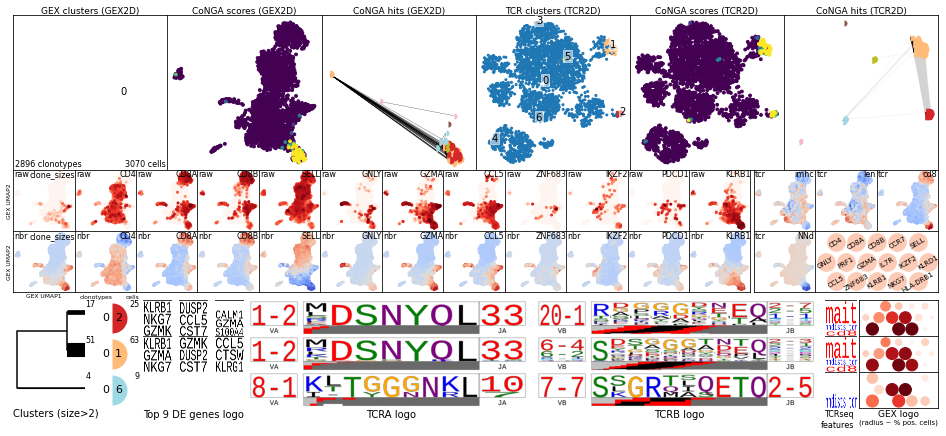

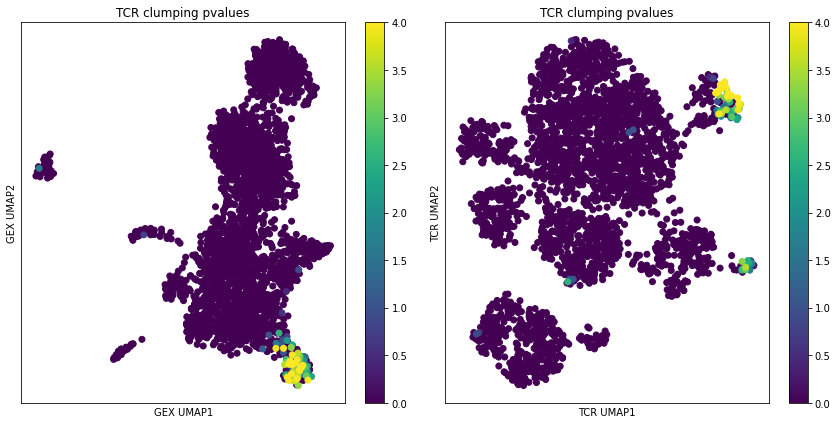

In [47]:
conga.plotting.make_tcr_clumping_plots(
    adata,
    results,
    nbrs_gex,
    nbrs_tcr,
    min_cluster_size_for_logos=3,
    pvalue_threshold_for_logos=1.,
    outfile_prefix=outfile_prefix
    )


## Run a simple implementation of the 'Hotspot' algorithm from the Yosef lab

This algorithm looks for features with a biased distribution over a neighbor graph. Here we use it to look for GEX features with a biased distribution over the TCR neighbor graph, and TCR features with a biased distribution over the GEX neighbor graph.

Here's a link to the preprint:

https://www.biorxiv.org/content/10.1101/2020.02.06.937805v1

In [48]:
nbr_frac = 0.1
nbrs_gex, nbrs_tcr = all_nbrs[nbr_frac]

gex_results = conga.correlations.find_hotspot_genes(adata, nbrs_tcr, pval_threshold=0.05)

tcr_results = conga.correlations.find_hotspot_tcr_features(adata, nbrs_gex, pval_threshold=0.05)

combo_results = pd.concat([gex_results, tcr_results])

tsvfile = f'{outfile_prefix}_hotspot_features_{nbr_frac:.3f}_nbrs.tsv'
combo_results.to_csv(tsvfile, sep='\t', index=False)


stacking extra columns! (2896, 14939) (2896, 10)
DONE stacking extra columns!
START computing H matrix <class 'scipy.sparse.csr.csr_matrix'>
computing H matrix      0   2896     0.000000
computing H matrix    500   2896    18.860681
computing H matrix   1000   2896    16.543343
computing H matrix   1500   2896    16.295807
computing H matrix   2000   2896    18.520937
computing H matrix   2500   2896    19.299028
zeros: 35 35 0
compute H_var
hotspot_gene:    0   154.423  0.0e+00 gex_cluster6
hotspot_gene:    1    77.193  0.0e+00 SLC4A10   
hotspot_gene:    2    61.763  0.0e+00 NKG7      
hotspot_gene:    3    53.833  0.0e+00 NCR3      
hotspot_gene:    4    52.288  0.0e+00 KLRB1     
hotspot_gene:    5    41.148  0.0e+00 GZMK      
hotspot_gene:    6    40.596  0.0e+00 S1PR5     
hotspot_gene:    7    36.918 1.8e-294 KLRG1     
hotspot_gene:    8    36.804 1.2e-292 CST7      
hotspot_gene:    9    34.836 5.1e-262 GZMA      
hotspot_gene:   10    32.768 1.3e-231 ZBTB16    
hotspot_gene:

making: hs_pbmc3_test1_hotspot_combo_features_0.100_nbrs_gex_umap.png
fastcluster is not available. Consider installing for faster performance.
computing pairwise X_pca_gex distances, (2896, 40)
computing linkage matrix from pairwise X_pca_gex distances
filling the score array for 171 features
close: 0.9603921851648929 NCR3 gex_cluster6
too many close: 1 gex_cluster6
close: 0.9598180710829244 GZMK NKG7
too many close: 1 NKG7
close: 0.9329882797156019 S1PR5 gex_cluster6
too many close: 2 gex_cluster6
close: 0.9194109163043783 KLRG1 KLRB1
too many close: 1 KLRB1
close: 0.9722101147259304 CST7 NKG7
too many close: 2 NKG7
close: 0.9387278209288223 GZMA NKG7
too many close: 3 NKG7
close: 0.9679183238988815 ZBTB16 gex_cluster6
too many close: 3 gex_cluster6
close: 0.9181490443655255 DUSP2 NKG7
too many close: 4 NKG7
close: 0.9778964721476173 ME1 gex_cluster6
too many close: 4 gex_cluster6
close: 0.9617366018185768 IL23R gex_cluster6
too many close: 5 gex_cluster6
close: 0.9733397888964807 CE

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


saving hs_pbmc3_test1_0.100_nbrs_combo_hotspot_features_vs_gex_clustermap_lessredundant.png
making: hs_pbmc3_test1_hotspot_combo_features_0.100_nbrs_tcr_umap.png
fastcluster is not available. Consider installing for faster performance.
computing pairwise X_pca_tcr distances, (2896, 50)
computing linkage matrix from pairwise X_pca_tcr distances
filling the score array for 171 features
close: 0.9674050309316833 NKG7 gex_cluster6
too many close: 1 gex_cluster6
close: 0.9699679433543589 NCR3 gex_cluster6
too many close: 2 gex_cluster6
close: 0.9618824801810599 KLRB1 gex_cluster6
too many close: 3 gex_cluster6
close: 0.9420018204600674 GZMK gex_cluster6
too many close: 4 gex_cluster6
close: 0.9728908166873681 S1PR5 gex_cluster6
too many close: 5 gex_cluster6
close: 0.9531246763016499 KLRG1 gex_cluster6
too many close: 6 gex_cluster6
close: 0.948994415646852 CST7 gex_cluster6
too many close: 7 gex_cluster6
close: 0.9498450428493785 GZMA gex_cluster6
too many close: 8 gex_cluster6
close: 0.95

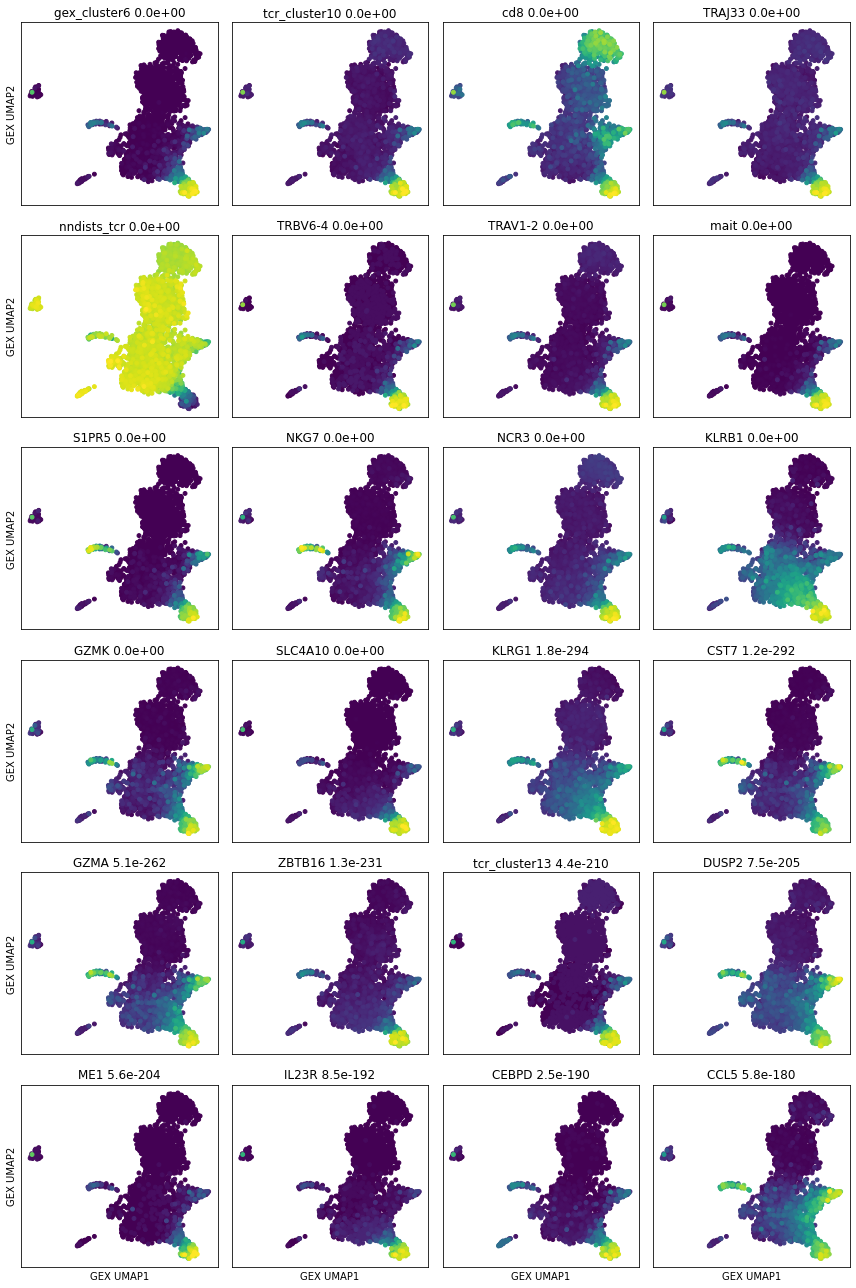

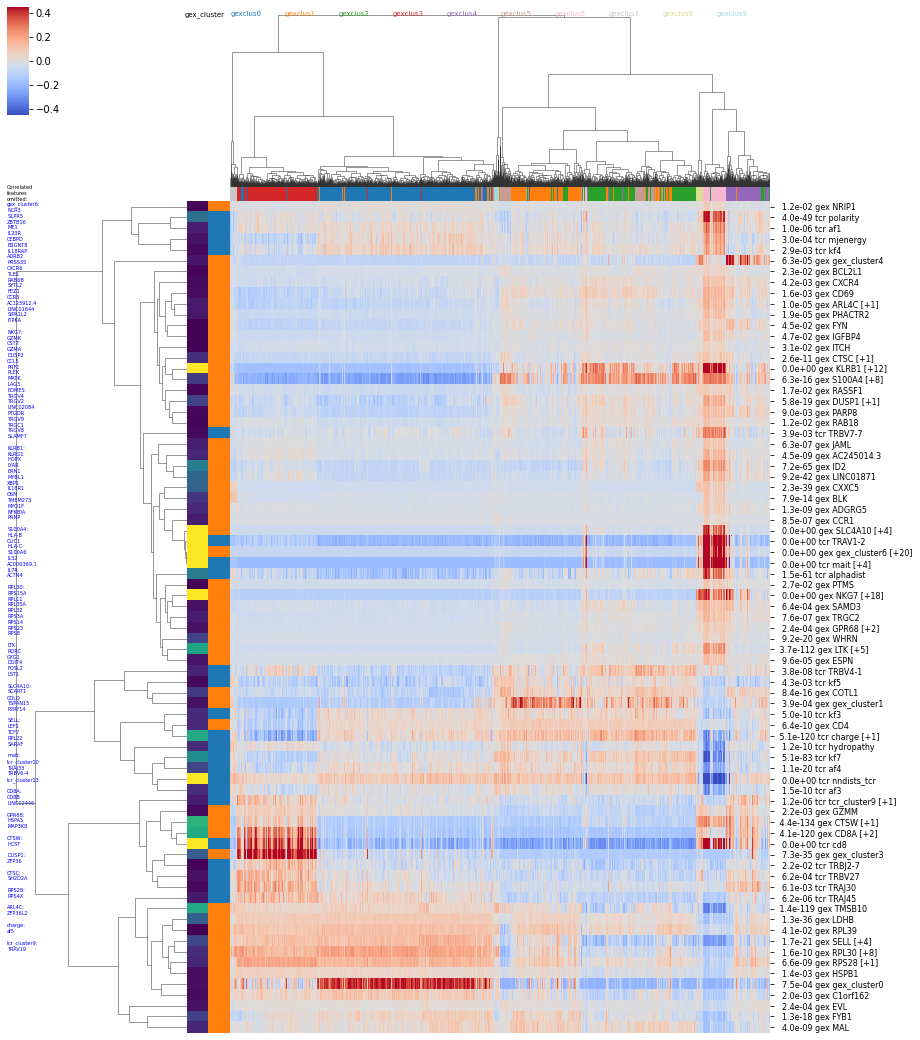

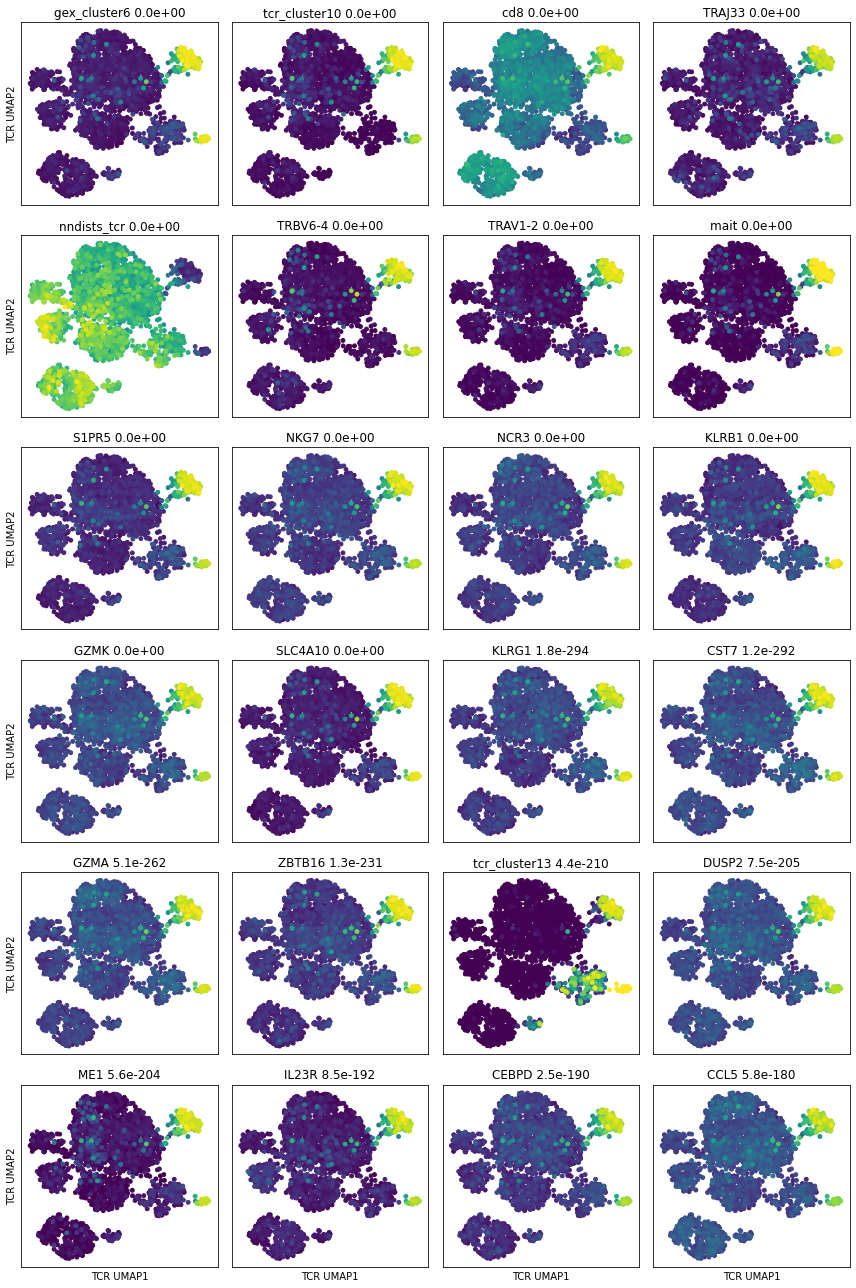

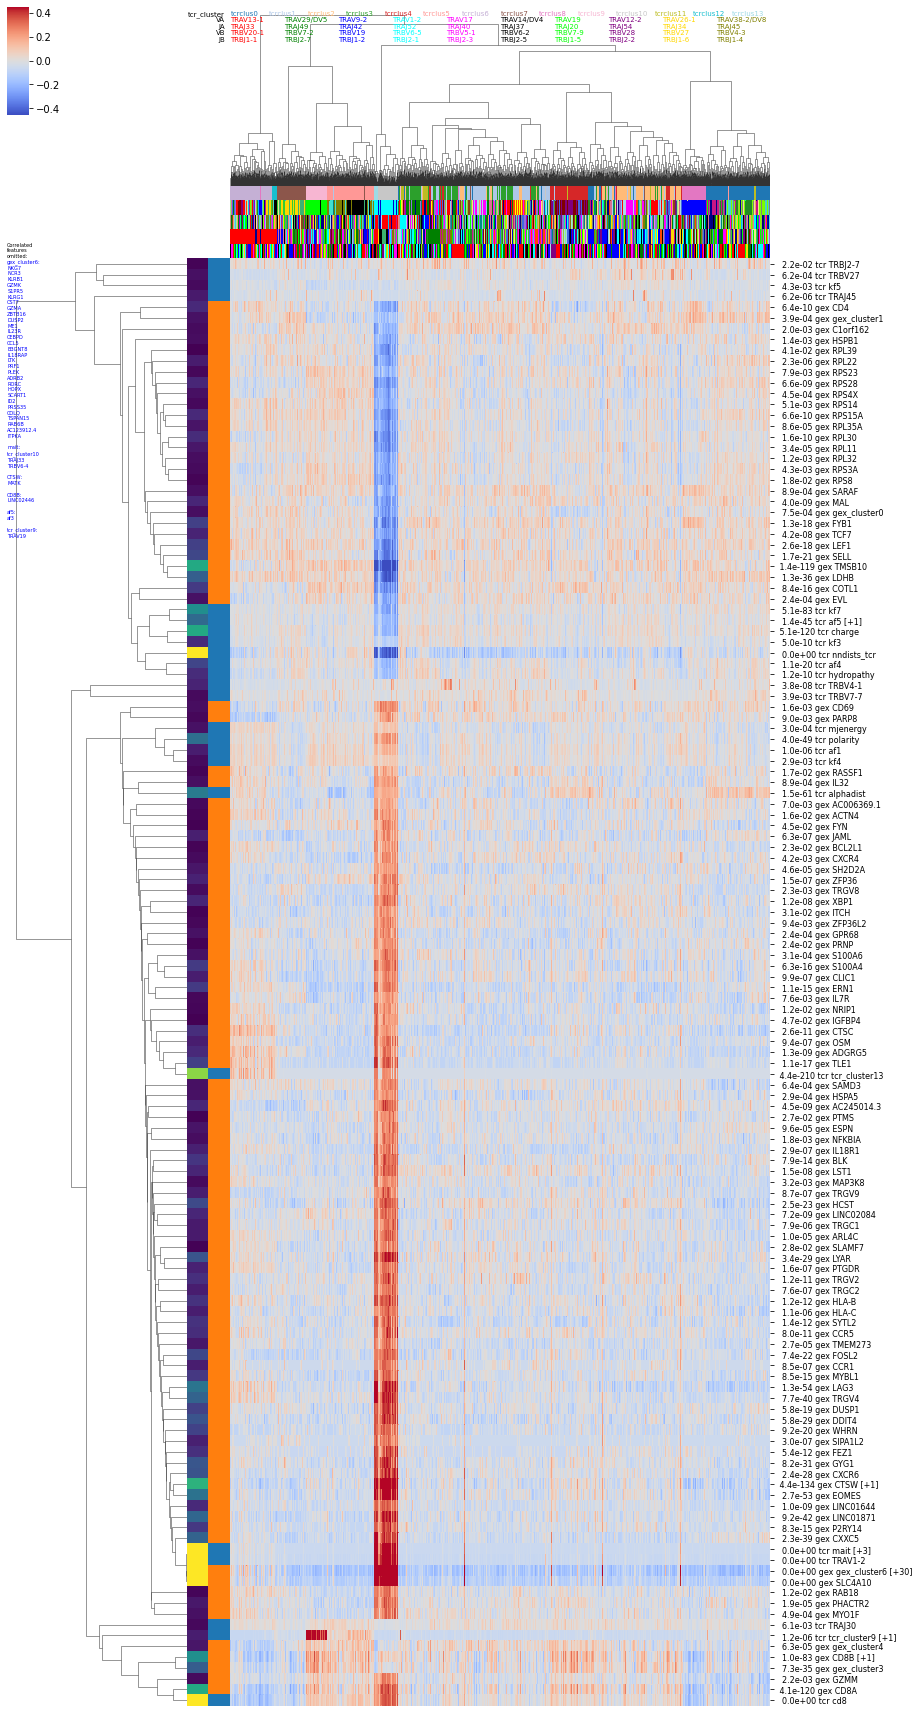

In [50]:
# this code is borrowed from conga/scripts/run_conga.py
tag, results = 'combo', combo_results

for plot_tag, plot_nbrs in [['gex',nbrs_gex], ['tcr',nbrs_tcr]]:
    # 2D UMAPs colored by nbr-averaged feature values
    pngfile = '{}_hotspot_{}_features_{:.3f}_nbrs_{}_umap.png'\
              .format(outfile_prefix, tag, nbr_frac, plot_tag)
    print('making:', pngfile)
    conga.plotting.plot_hotspot_umap(adata, plot_tag, results, pngfile, nbrs=plot_nbrs,
                                      compute_nbr_averages=True)

    ## clustermap of features versus cells
    features = list(results.feature)
    feature_labels = ['{:9.1e} {} {}'.format(x,y,z)
                      for x,y,z in zip(results.pvalue_adj, results.feature_type, results.feature)]
    min_pval = 1e-299 # dont want log10 of 0.0
    feature_scores = [np.sqrt(-1*np.log10(max(min_pval, x.pvalue_adj))) for x in results.itertuples()]

    # now a more compact version where we filter out redundant features
    pngfile = '{}_{:.3f}_nbrs_{}_hotspot_features_vs_{}_clustermap_lessredundant.png'\
              .format(outfile_prefix, nbr_frac, tag, plot_tag)
    # duplicates if linear correlation > 0.9
    redundancy_threshold = 0.9
    max_redundant_features = 0
    
    conga.plotting.plot_interesting_features_vs_clustermap(
        adata, features, pngfile, plot_tag, nbrs=plot_nbrs,
        compute_nbr_averages=True, feature_labels=feature_labels,
        feature_types = list(results.feature_type),
        max_redundant_features=max_redundant_features,
        redundancy_threshold=redundancy_threshold,
        feature_scores=feature_scores)


## Output png files

We can look at any of these more closely using the `display()` function and `Image.open`

In [52]:
!ls *png

hs_pbmc3_test1_0.100_nbrs_combo_hotspot_features_vs_gex_clustermap_lessredundant.png
hs_pbmc3_test1_0.100_nbrs_combo_hotspot_features_vs_tcr_clustermap_lessredundant.png
hs_pbmc3_test1_bicluster_logos.png
hs_pbmc3_test1_gex_nbr_graph_vs_tcr_features_panels.png
hs_pbmc3_test1_gex_nbr_graph_vs_tcr_features.png
hs_pbmc3_test1_hotspot_combo_features_0.100_nbrs_gex_umap.png
hs_pbmc3_test1_hotspot_combo_features_0.100_nbrs_tcr_umap.png
hs_pbmc3_test1_tcr_clumping_logos.png
hs_pbmc3_test1_tcr_clumping.png
hs_pbmc3_test1_tcr_nbr_graph_vs_gex_features_panels.png
hs_pbmc3_test1_tcr_nbr_graph_vs_gex_features.png


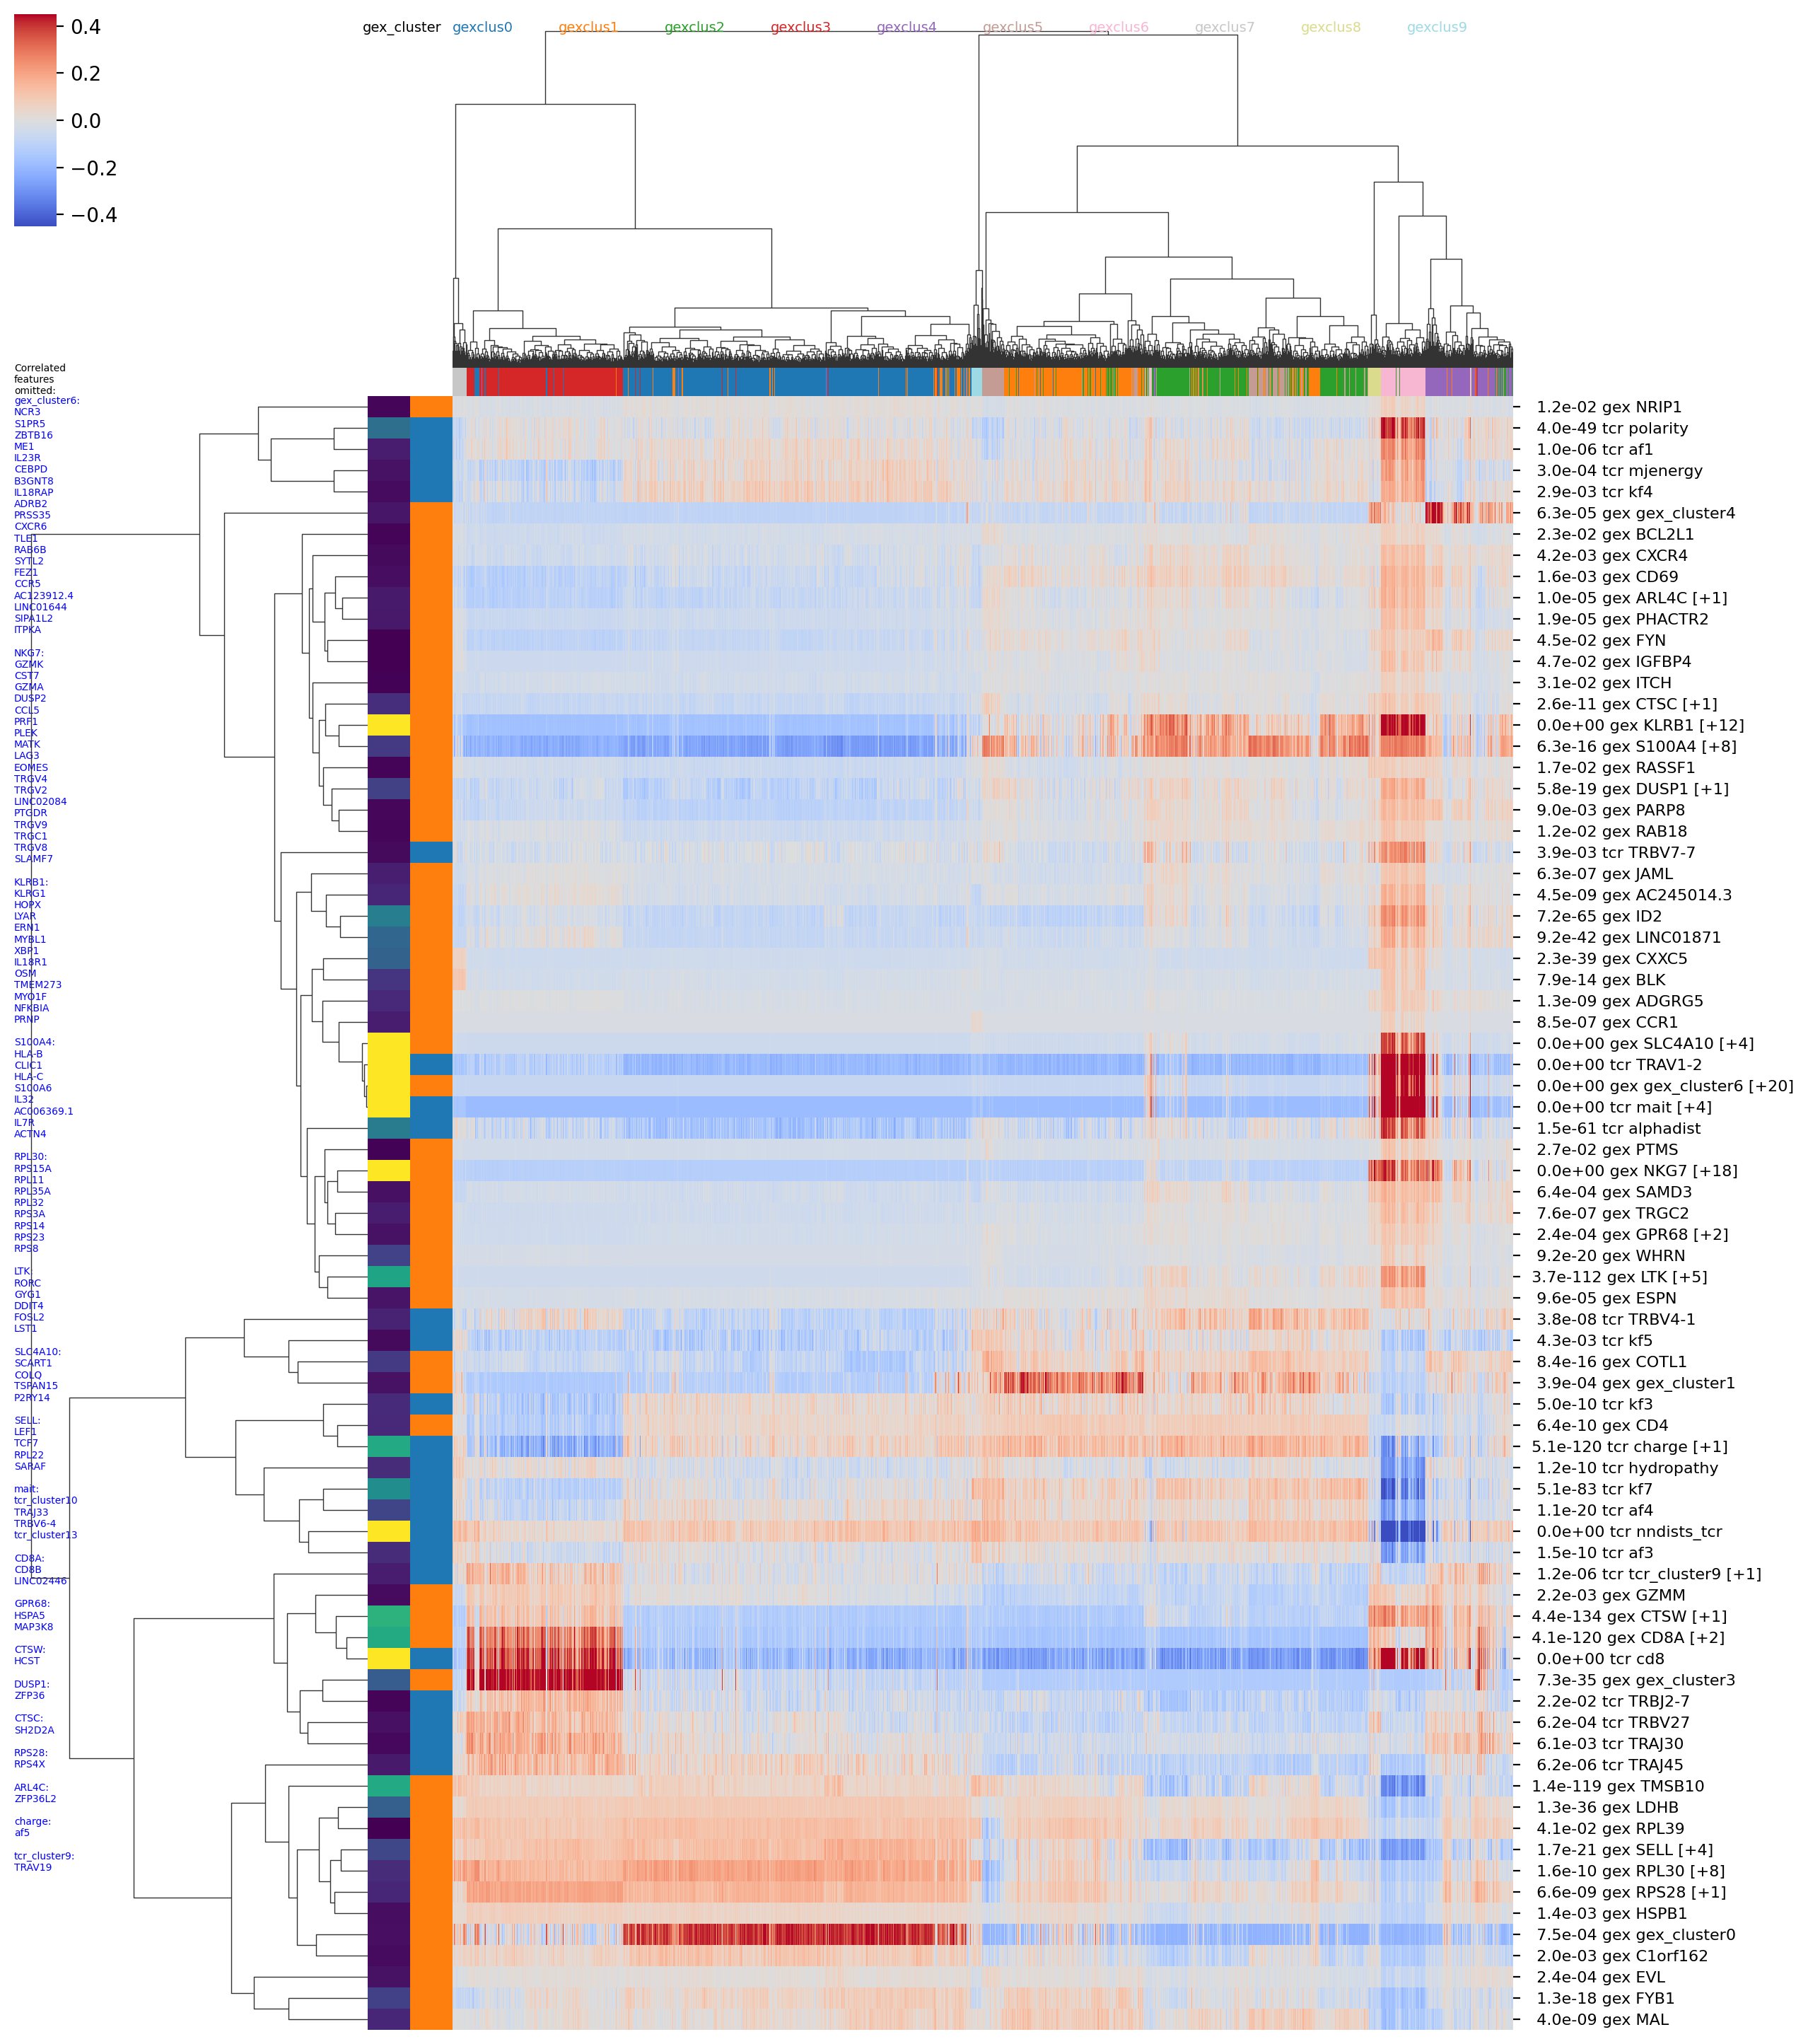

In [54]:
display(Image.open('hs_pbmc3_test1_0.100_nbrs_combo_hotspot_features_vs_gex_clustermap_lessredundant.png'))
